<a href="https://colab.research.google.com/github/AndreaBaldiExe/CLIP_DEBIASING/blob/main/Bias_Clip_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 0. Installazione Librerie ---
  Preparing metadata (setup.py) ... done
Librerie installate.
------------------------------
--- 1. Setup Ambiente e Dati ---
Mounted at /content/drive
Google Drive montato.
Device in uso: cuda
I risultati verranno salvati in: /content/drive/MyDrive/clip_debiasing/outputs_rn50_baseline_original_clip

--- 1.5 Decompressione Dataset Locali ---
Decompressione Pexels...
Decompressione Pets...
Decompressione FairFace...
Decompressione Challenge Set...
--- Decompressione completata ---

--- 1.6 Correzione Estensioni CSV Locale ---
File CSV locale già corretto.

--- Step 1 Completato ---

INIZIO STEP 2: CARICAMENTO MODELLO E DATI (con lib. CLIP)
Modello RN50 caricato con successo su cuda.
------------------------------

--- 2.6 Creazione DataLoaders ---
Pexels Loader creato (180 immagini).
Pets Loader creato (3669 immagini).
FairFace Loader creato (10954 immagini).
Challenge Loader creato (180 immagini).

--- Step 2 Completato ---

INIZIO STEP 3: VALUTAZIONE 

Pets Eval:   0%|          | 0/58 [00:00<?, ?it/s]

Valutazione Pets: Top-1=0.8517, Top-5=0.9921

--- 3.6.2 Esecuzione Test Bias Associazione (Pexels) ---
Inizio valutazione Association Bias con template: 'a photo of a {} {}'...


Association Bias Eval:   0%|          | 0/3 [00:00<?, ?it/s]

Valutazione Association Bias completata.
Bias raggruppato (Mean diff):
 profession  img_gender
doctor      female        0.010535
            male         -0.028137
engineer    female        0.016614
            male         -0.009550
nurse       female        0.011865
            male         -0.025895
Name: bias_score_diff, dtype: float64

Overall Absolute Bias Score: 0.0189

--- 3.6.3 Esecuzione Test Rappresentazione (FairFace) ---
Inizio valutazione Representation Bias (FairFace)...


FairFace Eval:   0%|          | 0/172 [00:00<?, ?it/s]

Valutazione FairFace completata.
Accuratezza Genere (Overall): 0.9047

Accuratezza Genere per Gruppo Etnico:
 race_group
Black              0.835476
Indian             0.890501
Southeast Asian    0.901767
East Asian         0.914839
Latino_Hispanic    0.918669
White              0.928537
Middle Eastern     0.942101
Name: gender_correct, dtype: float64

--- 3.6.4 Esecuzione Test Challenge Set (Baseline) ---
Inizio valutazione Association Bias con template: 'a photo of a {} {}'...


Association Bias Eval:   0%|          | 0/3 [00:00<?, ?it/s]

ERRORE: Immagine non trovata: /content/datasets/challenge_dataset/challenge_images_val/fe_07.jpeg
ERRORE: Immagine non trovata: /content/datasets/challenge_dataset/challenge_images_val/fe_07.jpeg
Valutazione Association Bias completata.
Bias raggruppato (Mean diff):
 profession  img_gender
doctor      female        0.006649
            male         -0.022453
engineer    female        0.019948
            male         -0.019128
nurse       female        0.006283
            male         -0.018652
Name: bias_score_diff, dtype: float64

Overall Absolute Bias Score: 0.0162

--- 3.6.5 Esecuzione PCA Spazio Testuale ---
Inizio analisi PCA (Spazio Testuale)...
Grafico PCA (Testo) salvato in: /content/drive/MyDrive/clip_debiasing/outputs_rn50_baseline_original_clip/baseline_pca_text_RN50_original_clip.png


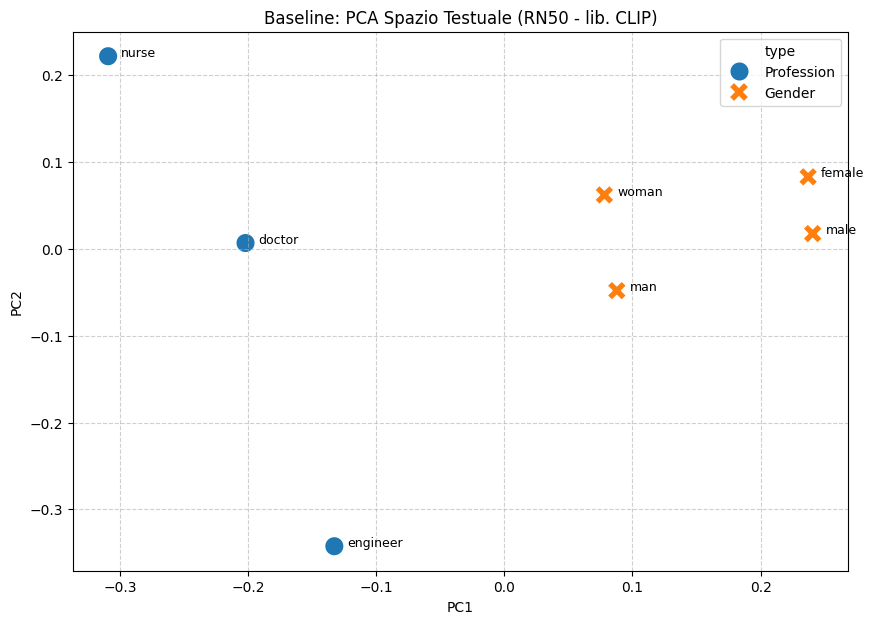


--- 3.7 Salvataggio Risultati Baseline su Drive ---
{
  "pets": {
    "top1_accuracy": 0.8517307168165713,
    "top5_accuracy": 0.9920959389479422
  },
  "pexels_bias": {
    "grouped_bias_records": [
      {
        "profession": "doctor",
        "img_gender": "female",
        "bias_score_diff": 0.01053466796875
      },
      {
        "profession": "doctor",
        "img_gender": "male",
        "bias_score_diff": -0.02813720703125
      },
      {
        "profession": "engineer",
        "img_gender": "female",
        "bias_score_diff": 0.01661376953125
      },
      {
        "profession": "engineer",
        "img_gender": "male",
        "bias_score_diff": -0.009549967447916667
      },
      {
        "profession": "nurse",
        "img_gender": "female",
        "bias_score_diff": 0.011865234375
      },
      {
        "profession": "nurse",
        "img_gender": "male",
        "bias_score_diff": -0.025895182291666666
      }
    ],
    "overall_abs_bias": 0.01891276041

In [2]:
# -----------------------------------------------
# STEP 0: INSTALLAZIONE LIBRERIE
# -----------------------------------------------
print("--- 0. Installazione Librerie ---")
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q ftfy regex tqdm pandas scikit-learn seaborn
print("Librerie installate.")
print("-" * 30)

# -----------------------------------------------
# STEP 1: SETUP AMBIENTE, PATH E DATI
# -----------------------------------------------
print("--- 1. Setup Ambiente e Dati ---")

import torch
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import random
import json
import seaborn as sns
import torchvision
import clip

from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from google.colab import drive

# 1.3 Montaggio Drive
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive montato.")
except Exception as e:
    print(f"Errore montaggio Drive: {e}")

# 1.4 Import e Costanti
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in uso: {DEVICE}")

# --- Path di Base (Google Drive) ---
BASE_DRIVE_PATH = Path("/content/drive/MyDrive/clip_debiasing/")

# --- Path Locali (Disco Colab) ---
LOCAL_DATA_DIR = Path("/content/datasets")
PEXELS_DIR = LOCAL_DATA_DIR / "pexels_evaluation_dataset"
PEXELS_CSV = PEXELS_DIR / "annotations.csv"
PEXELS_IMG_DIR = PEXELS_DIR / "images"
PETS_DIR = LOCAL_DATA_DIR / "Oxford_IIIT_Pet"
FAIRFACE_DIR = LOCAL_DATA_DIR / "fairface_eval"
FAIRFACE_VAL_CSV = FAIRFACE_DIR / "fairface_label_val.csv"
FAIRFACE_IMG_DIR = FAIRFACE_DIR
CHALLENGE_DIR = LOCAL_DATA_DIR / "challenge_dataset"
CHALLENGE_CSV = CHALLENGE_DIR / "annotations_challenge.csv"
CHALLENGE_IMG_DIR = CHALLENGE_DIR / "challenge_images_val"

# --- Path di Output (su Drive) ---
OUTPUT_DIR = BASE_DRIVE_PATH / "outputs_rn50_baseline_original_clip" # <-- Path nuovo
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"I risultati verranno salvati in: {OUTPUT_DIR}")

# 1.5 Decompressione Dataset
print("\n--- 1.5 Decompressione Dataset Locali ---")
!rm -rf "{LOCAL_DATA_DIR}"
LOCAL_DATA_DIR.mkdir(exist_ok=True)

PEXELS_ZIP_PATH = BASE_DRIVE_PATH / "data/pexels_evaluation_dataset.zip"
PETS_ZIP_PATH = BASE_DRIVE_PATH / "data/oxford-iiit-pet.zip"
FAIRFACE_ZIP_PATH = BASE_DRIVE_PATH / "data/fairface_eval.zip"
CHALLENGE_ZIP_PATH = BASE_DRIVE_PATH / "data/challenge_dataset.zip"

print("Decompressione Pexels...")
!unzip -o -q "{PEXELS_ZIP_PATH}" -d "{LOCAL_DATA_DIR}"
print("Decompressione Pets...")
!unzip -o -q "{PETS_ZIP_PATH}" -d "{LOCAL_DATA_DIR}"
print("Decompressione FairFace...")
!unzip -o -q "{FAIRFACE_ZIP_PATH}" -d "{LOCAL_DATA_DIR}"
print("Decompressione Challenge Set...")
!unzip -o -q "{CHALLENGE_ZIP_PATH}" -d "{LOCAL_DATA_DIR}"
!rm -rf "{LOCAL_DATA_DIR}/__MACOSX"
print("--- Decompressione completata ---")

print("\n--- 1.6 Correzione Estensioni CSV Locale ---")
try:
    df = pd.read_csv(CHALLENGE_CSV)
    if not df['file_name'].str.contains('.jpeg').any():
        df['file_name'] = df['file_name'].str.replace('.jpg', '.jpeg', regex=False)
        df.to_csv(CHALLENGE_CSV, index=False)
        print("File CSV locale corretto.")
    else:
        print("File CSV locale già corretto.")
except Exception as e:
    print(f"Errore correzione CSV: {e}")

print("\n--- Step 1 Completato ---")


# -----------------------------------------------
# STEP 2: CARICAMENTO MODELLO E DATI
# -----------------------------------------------
print("\n" + "=" * 50)
print("INIZIO STEP 2: CARICAMENTO MODELLO E DATI (con lib. CLIP)")
print("=" * 50)

# 2.1 Caricamento Modello e Processor CLIP (con lib. CLIP)
try:
    model, preprocess = clip.load("RN50", device=DEVICE)
    model.eval()
    print(f"Modello RN50 caricato con successo su {DEVICE}.")
except Exception as e:
    print(f"Errore durante il caricamento del modello: {e}")
print("-" * 30)

# 2.2 Definizione Dizionario Concettuale (Identico)
CONCEPT_DICTIONARY = {
    'professions': ['engineer', 'nurse', 'doctor'],
    'gender_pairs': [('man', 'woman'), ('male', 'female'), ('he', 'she'), ('boy', 'girl')],
    'train_templates': ["a photo of a {}", "a picture of a {}", "an image of a {}", "a portrait of a {}", "a good photo of a {}"],
    'gender_templates': ["a photo of a {}", "a picture of a {}"],
    'eval_templates_holdout': ["a high-quality image of a {}", "a cropped photo of a {}", "a {}."]
}
PROMPTS_FF_GENDER = ["a photo of a man", "a photo of a woman"]
PROMPTS_FF_RACE = [
    "a photo of a White person", "a photo of a Black person", "a photo of a Latino_Hispanic person",
    "a photo of an East Asian person", "a photo of a Southeast Asian person",
    "a photo of an Indian person", "a photo of a Middle Eastern person"
]
GENDER_MAP_FF = {'Male': 0, 'Female': 1}
RACE_MAP_FF = {'White': 0, 'Black': 1, 'Latino_Hispanic': 2, 'East Asian': 3, 'Southeast Asian': 4, 'Indian': 5, 'Middle Eastern': 6}

class PexelsDebiasDataset(Dataset):
    def __init__(self, csv_file, img_dir, preprocess_fn):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.preprocess = preprocess_fn

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        row = self.annotations.iloc[idx]
        img_path = os.path.join(self.img_dir, row['file_name'])
        try:
            image = Image.open(img_path).convert("RGB")
            processed_image = self.preprocess(image)
        except FileNotFoundError:
            print(f"ERRORE: Immagine non trovata: {img_path}")
            image = Image.new('RGB', (224, 224), color = 'red')
            processed_image = self.preprocess(image)
            return {
                'pixel_values': processed_image,
                'profession': 'ERROR',
                'gender': 'ERROR',
                'file_name': row['file_name']
            }
        return {
            'pixel_values': processed_image,
            'profession': row['profession'],
            'gender': row['query_gender'],
            'file_name': row['file_name']
        }

try:
    from torchvision.datasets import OxfordIIITPet
    temp_pet_data = OxfordIIITPet(root=PETS_DIR.parent, split="test", download=True)
    CLASS_NAMES_PETS = temp_pet_data.classes
    PROMPTS_PETS = [f"a photo of a {name.replace('_', ' ')}, a type of pet" for name in CLASS_NAMES_PETS]
except Exception as e:
    print(f"Errore nomi classi Pet: {e}")
    CLASS_NAMES_PETS, PROMPTS_PETS = [], []

class PetsZeroShotDataset(Dataset):
    def __init__(self, root_dir, preprocess_fn):
        self.tv_dataset = OxfordIIITPet(root=root_dir, split="test", download=False)
        self.preprocess = preprocess_fn

    def __len__(self):
        return len(self.tv_dataset)

    def __getitem__(self, idx):
        image, label = self.tv_dataset[idx]
        processed_image = self.preprocess(image)
        return {'pixel_values': processed_image, 'label': label}

class FairFaceDataset(Dataset):
    def __init__(self, csv_file, img_dir, preprocess_fn):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.preprocess = preprocess_fn
        self.annotations = self.annotations[
            self.annotations['gender'].isin(GENDER_MAP_FF.keys()) &
            self.annotations['race'].isin(RACE_MAP_FF.keys())
        ].reset_index(drop=True)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        row = self.annotations.iloc[idx]
        img_path = os.path.join(self.img_dir, row['file'])
        try:
            image = Image.open(img_path).convert("RGB")
            processed_image = self.preprocess(image)
        except FileNotFoundError:
            image = Image.new('RGB', (224, 224), color = 'red')
            processed_image = self.preprocess(image)
            return {
                'pixel_values': processed_image,
                'gender_label': -1,
                'race_label': -1,
                'race_group': 'ERROR'
            }

        return {
            'pixel_values': processed_image,
            'gender_label': GENDER_MAP_FF[row['gender']],
            'race_label': RACE_MAP_FF[row['race']],
            'race_group': row['race']
        }

print("\n--- 2.6 Creazione DataLoaders ---")
try:
    pexels_dataset = PexelsDebiasDataset(PEXELS_CSV, PEXELS_IMG_DIR, preprocess)
    pexels_loader = DataLoader(pexels_dataset, batch_size=64, shuffle=False, num_workers=2)
    print(f"Pexels Loader creato ({len(pexels_dataset)} immagini).")

    pets_dataset = PetsZeroShotDataset(PETS_DIR.parent, preprocess)
    pets_loader = DataLoader(pets_dataset, batch_size=64, shuffle=False, num_workers=2)
    print(f"Pets Loader creato ({len(pets_dataset)} immagini).")

    fairface_dataset = FairFaceDataset(FAIRFACE_VAL_CSV, FAIRFACE_IMG_DIR, preprocess)
    fairface_loader = DataLoader(fairface_dataset, batch_size=64, shuffle=False, num_workers=2)
    print(f"FairFace Loader creato ({len(fairface_dataset)} immagini).")

    challenge_dataset = PexelsDebiasDataset(CHALLENGE_CSV, CHALLENGE_IMG_DIR, preprocess)
    challenge_loader = DataLoader(challenge_dataset, batch_size=64, shuffle=False, num_workers=2)
    print(f"Challenge Loader creato ({len(challenge_dataset)} immagini).")

except Exception as e:
    print(f"Errore creazione DataLoader: {e}")

print("\n--- Step 2 Completato ---")


# -----------------------------------------------
# STEP 3: VALUTAZIONE BASELINE
# -----------------------------------------------
print("\n" + "=" * 50)
print("INIZIO STEP 3: VALUTAZIONE BASELINE (con lib. CLIP)")
print("=" * 50)

baseline_results = {}

# 3.1 Funzione Pets (CORRETTA)
def evaluate_pets(model, pets_loader, pets_prompts, device):
    print("Inizio valutazione Zero-Shot (OxfordIIITPet)...")
    with torch.no_grad():
        text_inputs = clip.tokenize(pets_prompts).to(device)
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    all_labels, all_preds_top1, all_preds_top5 = [], [], []
    with torch.no_grad():
        for batch in tqdm(pets_loader, desc="Pets Eval"):
            images, labels = batch['pixel_values'].to(device), batch['label'].to(device)
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            top5_preds = torch.topk(logits, 5, dim=-1)
            all_labels.append(labels.cpu())
            all_preds_top1.append(top5_preds.indices[:, 0].cpu())
            all_preds_top5.append(top5_preds.indices.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds_top1 = torch.cat(all_preds_top1).numpy()
    all_preds_top5 = torch.cat(all_preds_top5).numpy()
    top1_accuracy = accuracy_score(all_labels, all_preds_top1)
    top5_accuracy = np.mean([all_labels[i] in all_preds_top5[i] for i in range(len(all_labels))])
    print(f"Valutazione Pets: Top-1={top1_accuracy:.4f}, Top-5={top5_accuracy:.4f}")
    return {"top1_accuracy": top1_accuracy, "top5_accuracy": top5_accuracy}

# 3.2 Funzione Pexels
def evaluate_pexels_bias(model, pexels_loader, concept_dict, device,
                         eval_template="a photo of a {} {}"):
    print(f"Inizio valutazione Association Bias con template: '{eval_template}'...")
    professions = concept_dict['professions']
    eval_prompts, prompt_map = [], {}
    for prof in professions:
        for gender in ['male', 'female']:
            prompt = eval_template.format(gender, prof)
            prompt_map[(prof, gender)] = len(eval_prompts)
            eval_prompts.append(prompt)

    with torch.no_grad():
        text_inputs = clip.tokenize(eval_prompts).to(device)
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    results = []
    with torch.no_grad():
        for batch in tqdm(pexels_loader, desc="Association Bias Eval"):
            images = batch['pixel_values'].to(device)

            batch_size = images.shape[0]

            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = image_features @ text_features.T

            for i in range(batch_size):
                prof, gender_gt = batch['profession'][i], batch['gender'][i]
                if prof == 'ERROR':
                    continue
                sim_male_prompt = logits[i, prompt_map[(prof, 'male')]].item()
                sim_female_prompt = logits[i, prompt_map[(prof, 'female')]].item()
                results.append({
                    "profession": prof,
                    "img_gender": gender_gt,
                    "sim_male_prompt": sim_male_prompt,
                    "sim_female_prompt": sim_female_prompt,
                    "bias_score_diff": sim_female_prompt - sim_male_prompt
                })

    df = pd.DataFrame(results)
    if df.empty:
        print("ATTENZIONE: Nessun dato trovato.")
        return {"grouped_bias": pd.Series(), "overall_abs_bias": 0.0}

    bias_summary = df.groupby(['profession', 'img_gender'])['bias_score_diff'].mean()
    overall_abs_bias = df['bias_score_diff'].abs().mean()
    print("Valutazione Association Bias completata.")
    print("Bias raggruppato (Mean diff):\n", bias_summary)
    print(f"\nOverall Absolute Bias Score: {overall_abs_bias:.4f}")
    return {"grouped_bias": bias_summary, "overall_abs_bias": overall_abs_bias}

# 3.3 Funzione FairFace
def evaluate_fairface_bias(model, fairface_loader, gender_prompts, race_prompts, device):
    print("Inizio valutazione Representation Bias (FairFace)...")
    with torch.no_grad():
        text_inputs_gender = clip.tokenize(gender_prompts).to(device)
        text_features_gender = model.encode_text(text_inputs_gender)
        text_inputs_race = clip.tokenize(race_prompts).to(device)
        text_features_race = model.encode_text(text_inputs_race)
        text_features_gender /= text_features_gender.norm(dim=-1, keepdim=True)
        text_features_race /= text_features_race.norm(dim=-1, keepdim=True)

    results = []
    with torch.no_grad():
        for batch in tqdm(fairface_loader, desc="FairFace Eval"):
            images = batch['pixel_values'].to(device)
            g_labels, r_labels = batch['gender_label'].to(device), batch['race_label'].to(device)
            r_groups = batch['race_group']

            batch_size = images.shape[0]

            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            preds_gender = (100.0 * image_features @ text_features_gender.T).argmax(dim=-1)
            preds_race = (100.0 * image_features @ text_features_race.T).argmax(dim=-1)

            for i in range(batch_size):
                results.append({
                    "race_group": r_groups[i],
                    "gender_correct": (preds_gender[i] == g_labels[i]).item(),
                    "race_correct": (preds_race[i] == r_labels[i]).item(),
                })

    df = pd.DataFrame(results)
    if df.empty:
        print("ATTENZIONE: Nessun dato FairFace trovato.")
        return {"overall_gender_acc": 0.0, "overall_race_acc": 0.0, "gender_acc_by_race": pd.Series()}

    overall_gender_acc = df['gender_correct'].mean()
    overall_race_acc = df['race_correct'].mean()
    gender_acc_by_race = df.groupby('race_group')['gender_correct'].mean().sort_values()
    print("Valutazione FairFace completata.")
    print(f"Accuratezza Genere (Overall): {overall_gender_acc:.4f}")
    print("\nAccuratezza Genere per Gruppo Etnico:\n", gender_acc_by_race)
    return {
        "overall_gender_acc": overall_gender_acc,
        "overall_race_acc": overall_race_acc,
        "gender_acc_by_race": gender_acc_by_race
    }

def plot_text_pca(model, concept_dict, device, title, save_path=None):
    print("Inizio analisi PCA (Spazio Testuale)...")
    prof_labels = concept_dict['professions']
    gender_labels = ['man', 'woman', 'male', 'female']
    all_labels = prof_labels + gender_labels
    prompts = [f"a photo of a {label}" for label in all_labels]
    with torch.no_grad():
        text_inputs = clip.tokenize(prompts).to(device)
        text_features = model.encode_text(text_inputs)
        text_features_norm = text_features / text_features.norm(dim=-1, keepdim=True)

    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(text_features_norm.cpu().numpy())
    df = pd.DataFrame(embeddings_2d, columns=['PC1', 'PC2'])
    df['label'] = all_labels
    df['type'] = ['Profession'] * len(prof_labels) + ['Gender'] * len(gender_labels)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='type', style='type', s=200)
    for i, row in df.iterrows():
        plt.text(row['PC1'] + 0.01, row['PC2'], row['label'], fontsize=9)
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Grafico PCA (Testo) salvato in: {save_path}")
    plt.show()

def convert_results_to_json_serializable(results):
    results_copy = results.copy()
    pexels_style_keys = ['pexels_bias', 'challenge_bias']
    for key in pexels_style_keys:
        if key in results_copy and results_copy[key] is not None:
            if not results_copy[key]['grouped_bias'].empty:
                grouped_data = results_copy[key]['grouped_bias'].reset_index().to_dict('records')
            else:
                grouped_data = []
            results_copy[key] = {
                'grouped_bias_records': grouped_data,
                'overall_abs_bias': results_copy[key]['overall_abs_bias']
            }
    if 'fairface_bias' in results_copy and results_copy['fairface_bias'] is not None:
        results_copy['fairface_bias'] = results_copy['fairface_bias'].copy()
        if 'gender_acc_by_race' in results_copy['fairface_bias'] and not results_copy['fairface_bias']['gender_acc_by_race'].empty:
            results_copy['fairface_bias']['gender_acc_by_race'] = results_copy['fairface_bias']['gender_acc_by_race'].to_dict()
        else:
            results_copy['fairface_bias']['gender_acc_by_race'] = {}
    return results_copy

# -----------------------------------------------
# 3.6 ESECUZIONE VALUTAZIONE BASELINE
# -----------------------------------------------
try:
    with torch.no_grad():
        print("\n--- 3.6.1 Esecuzione Test Zero-Shot (Pets) ---")
        baseline_results["pets"] = evaluate_pets(
            model, pets_loader, PROMPTS_PETS, DEVICE
        )

        print("\n--- 3.6.2 Esecuzione Test Bias Associazione (Pexels) ---")
        baseline_results["pexels_bias"] = evaluate_pexels_bias(
            model, pexels_loader, CONCEPT_DICTIONARY, DEVICE
        )

        print("\n--- 3.6.3 Esecuzione Test Rappresentazione (FairFace) ---")
        baseline_results["fairface_bias"] = evaluate_fairface_bias(
            model, fairface_loader, PROMPTS_FF_GENDER, PROMPTS_FF_RACE, DEVICE
        )

        print("\n--- 3.6.4 Esecuzione Test Challenge Set (Baseline) ---")
        baseline_results["challenge_bias"] = evaluate_pexels_bias(
            model, challenge_loader, CONCEPT_DICTIONARY, DEVICE
        )

    print("\n--- 3.6.5 Esecuzione PCA Spazio Testuale ---")
    plot_text_pca(
        model, CONCEPT_DICTIONARY, DEVICE,
        title="Baseline: PCA Spazio Testuale (RN50 - lib. CLIP)",
        save_path=OUTPUT_DIR / "baseline_pca_text_RN50_original_clip.png"
    )

except Exception as e:
    print(f"\nERRORE DURANTE LA VALUTAZIONE BASELINE: {e}")
    import traceback
    traceback.print_exc()

# 3.7 Salvataggio Risultati
print("\n--- 3.7 Salvataggio Risultati Baseline su Drive ---")
try:
    serializable_baseline_results = convert_results_to_json_serializable(baseline_results)
    print(json.dumps(serializable_baseline_results, indent=2))
    baseline_save_path = OUTPUT_DIR / "baseline_results.json"
    with open(baseline_save_path, 'w') as f:
        json.dump(serializable_baseline_results, f, indent=4)
    print(f"Risultati Baseline (RN50) salvati in: {baseline_save_path}")
except Exception as e:
    print(f"Errore durante il salvataggio dei risultati: {e}")

print("\n--- SCRIPT DI ANALISI BASELINE COMPLETATO ---")